In [5]:
from skfeature.function.similarity_based import fisher_score
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
import glob
import cv2 as cv
import pandas as pd
import pickle
import os
from random import choices
import numpy as np
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from scipy.stats import mode
from utilities import test
from utilities import move
from image_process import preprocess
from image_process import appply_filter
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

In [6]:
def preprocess(img,size=(100,100)):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized=cv.resize(gray,size)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    normalized = clahe.apply(resized)
    return normalized
    
def appply_filter(img,kernels,lables):
    df=pd.DataFrame()
    df['Original Image']=img.reshape(-1)
    raw_features=[]
    for kernel,label in zip(kernels,lables):
        fimg = cv.filter2D(img,cv.CV_8UC3,kernel)
        raw_features.append(fimg)
        df[label]=fimg.reshape(-1)
    return df,raw_features  

def generate_filters(ksize=5,phi=0):
    kernels=[]
    lables=[]
    for theta in range(4):
        theta=theta/4.*np.pi
        for sigma in(1,3,5):
            for lamda in np.arange(0,np.pi,np.pi/4):
                for gamma in(0.05,0.5):
                    label = "Gabour "+" ".join(str(x) for x in[theta,sigma,lamda,gamma])
                    kernel=cv.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,phi,ktype=cv.CV_32F)
                    if np.isnan(kernel[0][0]):continue
                    kernels.append(kernel)
                    lables.append(label)
    return kernels,lables

def form_data(frame,size=(32,32)):
    kernels,lables=generatte_filters()
    X=[]
    Y=[]
    for i in range(frame.shape[0]):
        path=os.path.relpath(frame.iloc[i]['file'])
        #print(path)
        im=cv.imread(path)
        try:
            len(im)
        except:
            print(path)
            continue
        cls=[int(frame.iloc[i]['class'])]
        proc_im=preprocess(im,size)
        data_f,raw_features=appply_filter(proc_im,kernels,lables)
        feat_array=np.array(data_f.to_numpy().T)
        X.append(feat_array)
        Y.append(cls*data_f.shape[1])
    X=np.array(X)
    Y=np.array(Y)
    X=X.reshape(-1,X.shape[-1])
    Y=Y.reshape(-1)
    return X,Y

def read_images():
    files =glob.glob(r"./cats"+"/*.jpg")
    data =pd.DataFrame({'file':files,'class':[1]*len(files)})
    other_files=glob.glob(r"./dogs"+"/*.jpg")
    other_data=pd.DataFrame({'file':other_files,'class':[0]*len(other_files)})
    data=data.append(other_data)
    data = data.sample(frac=1).reset_index(drop=True)
    return data

In [7]:
image_names=read_images()

C:\Users\nazar\AppData\Local\Temp\ipykernel_27424\753361748.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


In [8]:
k,l=generate_filters()
X=[]
Y=[]
for file,cls in zip(image_names['file'],image_names['class']):
    try:
        im=cv.imread(file)
        preprocessed=preprocess(im,size=(32,32))
        dataframe,raw_features=appply_filter(preprocessed,k,l)
        pd.DataFrame(dataframe).sample(5)
        arr=[dataframe.iloc[:,i].to_numpy() for i in range(1,73)]
        X.append(arr)
        Y.append(cls)
    except:
        continue

In [9]:
def calculate_score(X,Y,norm_type=np.inf):
    X=np.array(X)
    Y=np.array(Y)
    i=0
    scores=[]
    for k in range(0,X.shape[1]):
        i=i+1
        m1k=X[:,k][Y==0].mean(0)
        m2k=X[:,k][Y==1].mean(0)
        sig1k=X[:,k][Y==0].std(0)
        sig2k=X[:,k][Y==1].std(0)
        j=(norm(m1k-m2k,norm_type)**2)/(norm(sig1k**2,norm_type)+norm(sig2k**2,norm_type))
        scores.append(j)
    return scores

In [10]:
scores=calculate_score(X,Y);
ScoreBoard=pd.DataFrame(scores,[i for i in range(0,72)])
ScoreBoard=ScoreBoard.dropna()

C:\Users\nazar\AppData\Local\Temp\ipykernel_27424\424302473.py:12: RuntimeWarning: invalid value encountered in double_scalars
  j=(norm(m1k-m2k,norm_type)**2)/(norm(sig1k**2,norm_type)+norm(sig2k**2,norm_type))


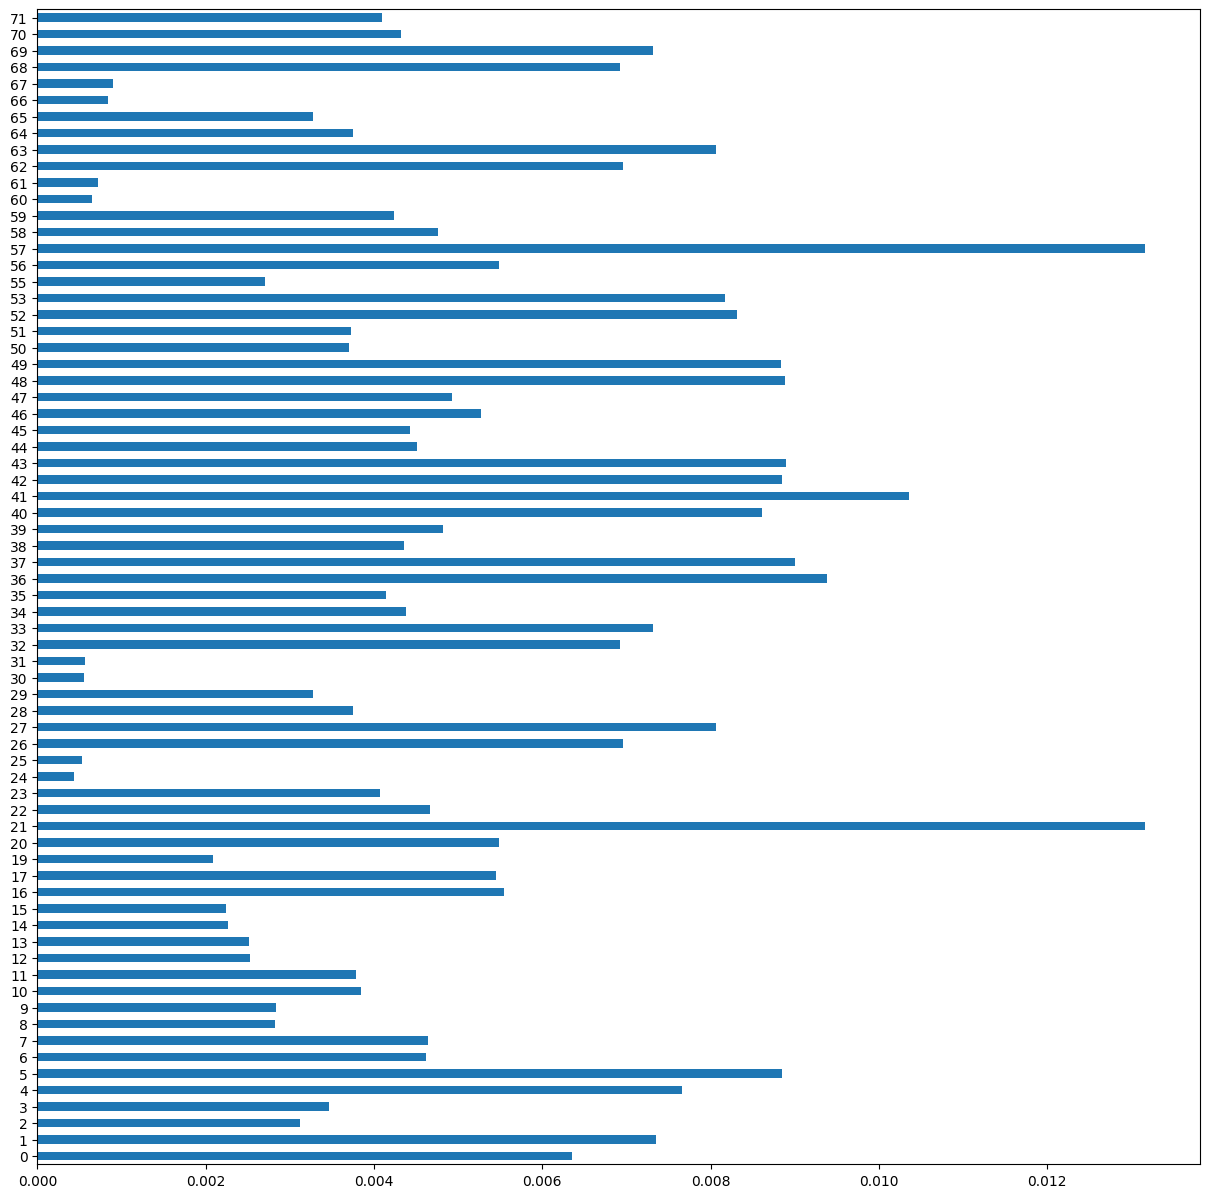

In [11]:
ScoreBoard.plot.barh(figsize=(15,15),legend=None);

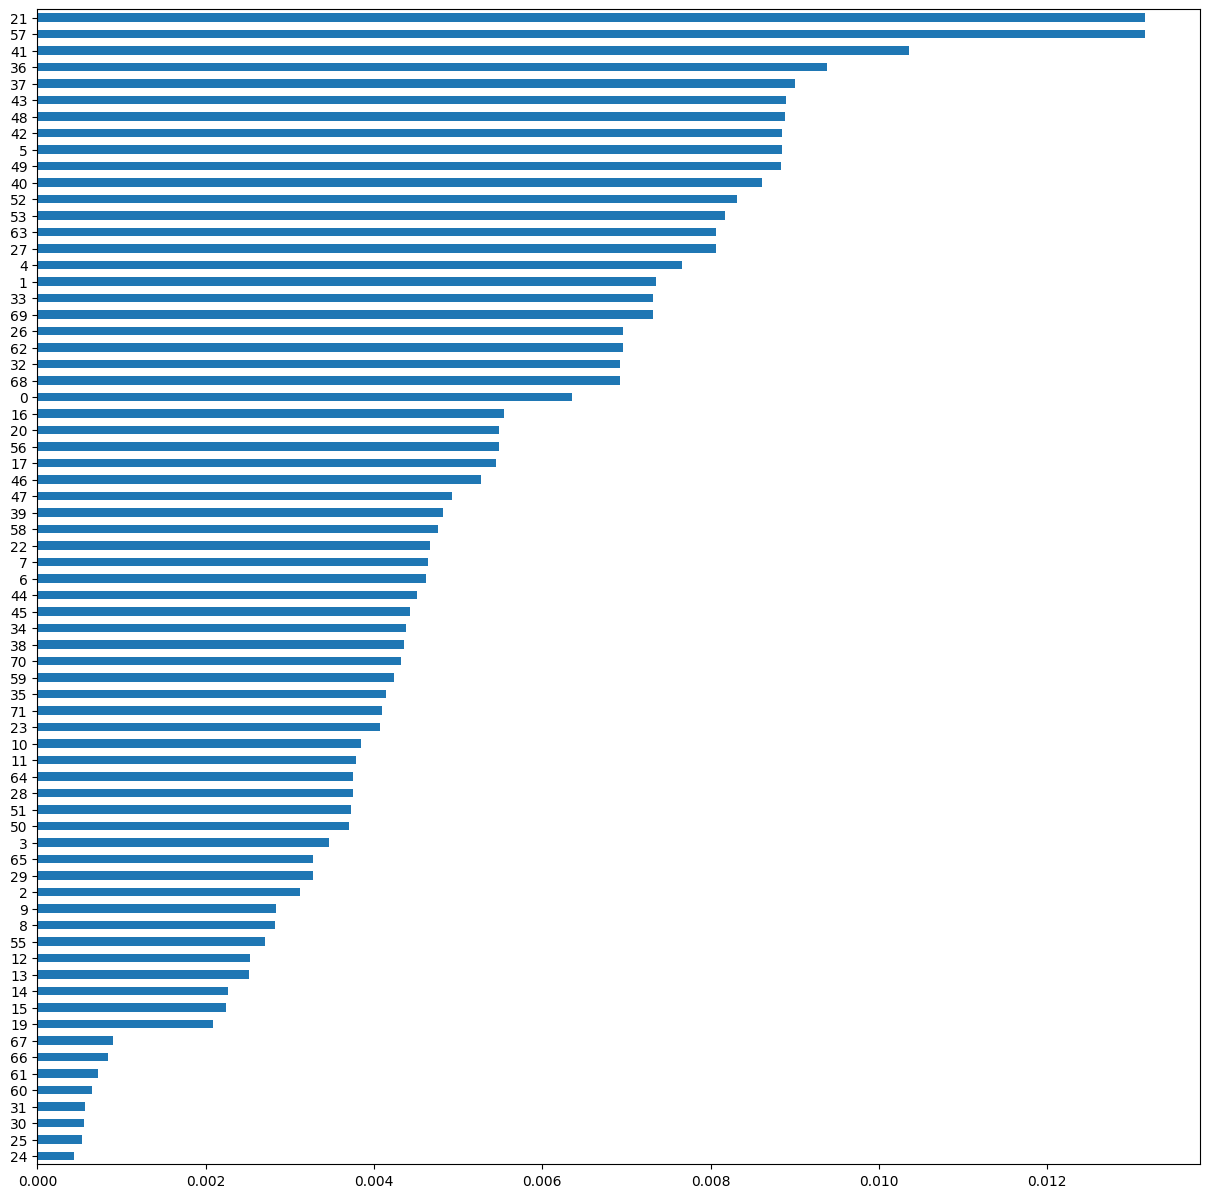

In [12]:
ScoreBoard=ScoreBoard.sort_values(by=0)
ScoreBoard.plot.barh(figsize=(15,15),legend=None);

In [13]:
def form_data(frame,kernels=None,lables=None,size=(32,32)):
    if kernels==None or lables==None:
        kernels,lables=generatte_filters()
    X=[]
    Y=[]
    for i in range(frame.shape[0]):
        path=os.path.relpath(frame.iloc[i]['file'])
        #print(path)
        im=cv.imread(path)
        try:
            len(im)
        except:
            print(path)
            continue
        cls=[int(frame.iloc[i]['class'])]
        proc_im=preprocess(im,size)
        data_f,raw_features=appply_filter(proc_im,kernels,lables)
        feat_array=np.array(data_f.to_numpy().T)
        X.append(feat_array)
        Y.append(cls*data_f.shape[1])
    X=np.array(X)
    Y=np.array(Y)
    X=X.reshape(-1,X.shape[-1])
    Y=Y.reshape(-1)
    return X,Y

In [14]:
start=time.time()
Xfull,Yfull=form_data(read_images(),k,l)
end=time.time()-start
print(end)

C:\Users\nazar\AppData\Local\Temp\ipykernel_27424\753361748.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Abyssinian_34.jpg
cats\Egyptian_Mau_145.jpg
cats\Egyptian_Mau_167.jpg
cats\Egyptian_Mau_139.jpg
cats\Egyptian_Mau_191.jpg
cats\Egyptian_Mau_177.jpg
136.3372938632965


In [61]:
Xtst=Xfull[:25000,:]
Ytst=Yfull[:25000]

In [62]:
 MLCFFmodel3layer = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)

In [63]:
start=time.time()
MLCFFmodel3layer.fit(Xtst,Ytst)
end=time.time()-start
print(end)

Iteration 1, loss = 8.75086683
Iteration 2, loss = 5.21808728
Iteration 3, loss = 3.64594075
Iteration 4, loss = 2.79722347
Iteration 5, loss = 1.43090693
Iteration 6, loss = 1.18086388
Iteration 7, loss = 0.67296801
Iteration 8, loss = 0.69072913
Iteration 9, loss = 0.45761646
Iteration 10, loss = 0.41205655
Iteration 11, loss = 0.57741467
Iteration 12, loss = 0.49746198
Iteration 13, loss = 0.44492840
Iteration 14, loss = 0.25768645
Iteration 15, loss = 0.27095372
Iteration 16, loss = 0.27263320
Iteration 17, loss = 0.20778996
Iteration 18, loss = 0.20163080
Iteration 19, loss = 0.19256428
Iteration 20, loss = 0.17679967
Iteration 21, loss = 0.17709751
Iteration 22, loss = 0.18501581
Iteration 23, loss = 0.23880173
Iteration 24, loss = 0.18160336
Iteration 25, loss = 0.16086229
Iteration 26, loss = 0.15164755
Iteration 27, loss = 0.16071183
Iteration 28, loss = 0.16310522
Iteration 29, loss = 0.16035110
Iteration 30, loss = 0.16565139
Iteration 31, loss = 0.15920638
Iteration 32, los

In [64]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer,Xtst,Ytst);

In [65]:
 MLCFFmodel3layer50 = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)

In [66]:
k50=[k[i] for i in ScoreBoard.iloc[-50:].index]
l50=[l[i] for i in ScoreBoard.iloc[-50:].index]

In [67]:
start=time.time()
Xfull50,Yfull50=form_data(read_images(),k50,l50)
end=time.time()-start
print(end)

C:\Users\nazar\AppData\Local\Temp\ipykernel_21292\2499032716.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Egyptian_Mau_167.jpg
cats\Egyptian_Mau_145.jpg
cats\Abyssinian_34.jpg
cats\Egyptian_Mau_139.jpg
cats\Egyptian_Mau_177.jpg
cats\Egyptian_Mau_191.jpg
172.29346299171448


In [68]:
Xtst50=Xfull50[:25000,:]
Ytst50=Yfull50[:25000]
start=time.time()
MLCFFmodel3layer50.fit(Xtst50,Ytst50)
end=time.time()-start
print(end)

Iteration 1, loss = 7.45815099
Iteration 2, loss = 2.84558642
Iteration 3, loss = 1.51760932
Iteration 4, loss = 1.00047296
Iteration 5, loss = 0.62250719
Iteration 6, loss = 0.44203501
Iteration 7, loss = 0.45504025
Iteration 8, loss = 0.39990627
Iteration 9, loss = 0.23426645
Iteration 10, loss = 0.20495965
Iteration 11, loss = 0.16237209
Iteration 12, loss = 0.17892915
Iteration 13, loss = 0.12639326
Iteration 14, loss = 0.13676949
Iteration 15, loss = 0.10907119
Iteration 16, loss = 0.09893969
Iteration 17, loss = 0.09714277
Iteration 18, loss = 0.09075190
Iteration 19, loss = 0.08338407
Iteration 20, loss = 0.08565593
Iteration 21, loss = 0.07137363
Iteration 22, loss = 0.07798005
Iteration 23, loss = 0.05715900
Iteration 24, loss = 0.06003247
Iteration 25, loss = 0.09890346
Iteration 26, loss = 0.15728522
Iteration 27, loss = 0.10483745
Iteration 28, loss = 0.08428768
Iteration 29, loss = 0.09523558
Iteration 30, loss = 0.09470669
Iteration 31, loss = 0.09269877
Iteration 32, los

In [69]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer50,Xtst50,Ytst50);

In [80]:
 MLCFFmodel3layer30 = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)
k30=[k[i] for i in ScoreBoard.iloc[-30:].index]
l30=[l[i] for i in ScoreBoard.iloc[-30:].index]
start=time.time()
Xfull30,Yfull30=form_data(read_images(),k30,l30)
end=time.time()-start
print(end)
Xtst30=Xfull30[:25000,:]
Ytst30=Yfull30[:25000]
start=time.time()
MLCFFmodel3layer30.fit(Xtst30,Ytst30)
end=time.time()-start
print(end)
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer30,Xtst30,Ytst30);

C:\Users\nazar\AppData\Local\Temp\ipykernel_21292\2499032716.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Egyptian_Mau_145.jpg
cats\Abyssinian_34.jpg
cats\Egyptian_Mau_139.jpg
cats\Egyptian_Mau_177.jpg
cats\Egyptian_Mau_191.jpg
cats\Egyptian_Mau_167.jpg
135.1659893989563
Iteration 1, loss = 7.29876117
Iteration 2, loss = 2.07403961
Iteration 3, loss = 0.80815516
Iteration 4, loss = 0.43780061
Iteration 5, loss = 0.32942831
Iteration 6, loss = 0.27391259
Iteration 7, loss = 0.24041619
Iteration 8, loss = 0.22075000
Iteration 9, loss = 0.20384731
Iteration 10, loss = 0.18844868
Iteration 11, loss = 0.17811294
Iteration 12, loss = 0.17172131
Iteration 13, loss = 0.16324997
Iteration 14, loss = 0.17509993
Iteration 15, loss = 0.15971393
Iteration 16, loss = 0.16059895
Iteration 17, loss = 0.17170011
Iteration 18, loss = 0.15827160
Iteration 19, loss = 0.16437472
Iteration 20, loss = 0.14281046
Iteration 21, loss = 0.16081643
Iteration 22, loss = 0.15056026
Iteration 23, loss = 0.15635427
Iteration 24, loss = 0.13982229
Iteration 25, loss = 0.13883040
Iteration 26, loss = 0.13771020
Iterat

C:\Users\nazar\AppData\Local\Temp\ipykernel_21292\2499032716.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Egyptian_Mau_145.jpg
cats\Egyptian_Mau_177.jpg
cats\Egyptian_Mau_167.jpg
cats\Egyptian_Mau_191.jpg
cats\Egyptian_Mau_139.jpg
cats\Abyssinian_34.jpg
98.50894808769226
Iteration 1, loss = 5.50226899
Iteration 2, loss = 0.87229401
Iteration 3, loss = 0.54006331
Iteration 4, loss = 0.47181736
Iteration 5, loss = 0.43550975
Iteration 6, loss = 0.40026267
Iteration 7, loss = 0.36568315
Iteration 8, loss = 0.33100591
Iteration 9, loss = 0.29918191
Iteration 10, loss = 0.27641151
Iteration 11, loss = 0.25418558
Iteration 12, loss = 0.23030857
Iteration 13, loss = 0.23795080
Iteration 14, loss = 0.23417550
Iteration 15, loss = 0.22983674
Iteration 16, loss = 0.22179425
Iteration 17, loss = 0.22541653
Iteration 18, loss = 0.21861222
Iteration 19, loss = 0.20966188
Iteration 20, loss = 0.20557230
Iteration 21, loss = 0.20749312
Iteration 22, loss = 0.20271938
Iteration 23, loss = 0.20452292
Iteration 24, loss = 0.19421388
Iteration 25, loss = 0.18950356
Iteration 26, loss = 0.18575781
Iterat

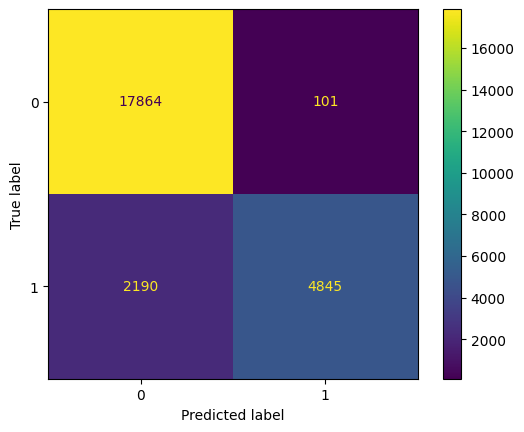

In [76]:
 MLCFFmodel3layer20 = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)
k20=[k[i] for i in ScoreBoard.iloc[-20:].index]
l20=[l[i] for i in ScoreBoard.iloc[-20:].index]
start=time.time()
Xfull20,Yfull20=form_data(read_images(),k20,l20)
end=time.time()-start
print(end)
Xtst20=Xfull20[:25000,:]
Ytst20=Yfull20[:25000]
start=time.time()
MLCFFmodel3layer20.fit(Xtst20,Ytst20)
end=time.time()-start
print(end)
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer20,Xtst20,Ytst20);

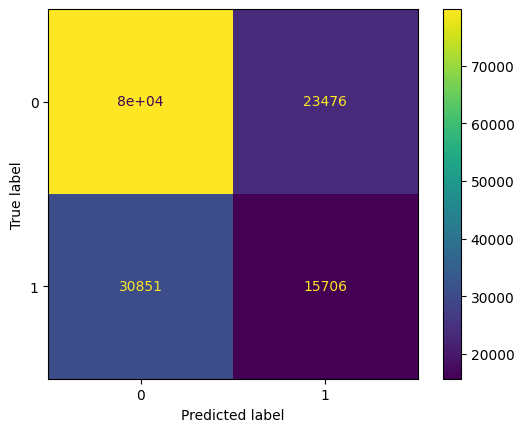

In [72]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer20,Xfull20,Yfull20);

In [73]:
93.4

93.4

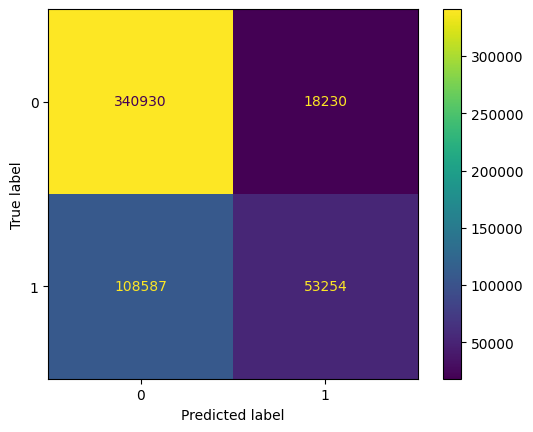

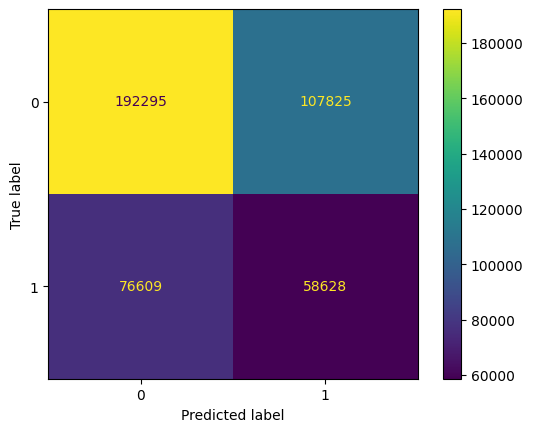

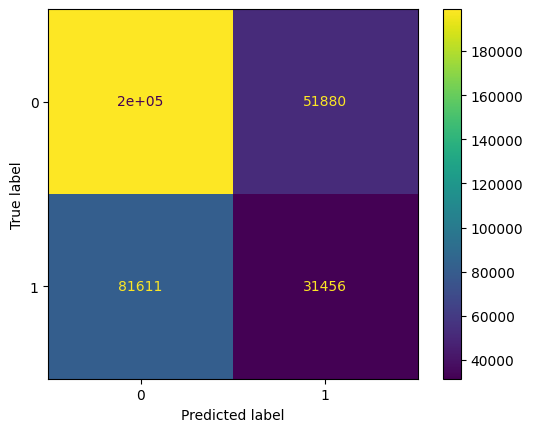

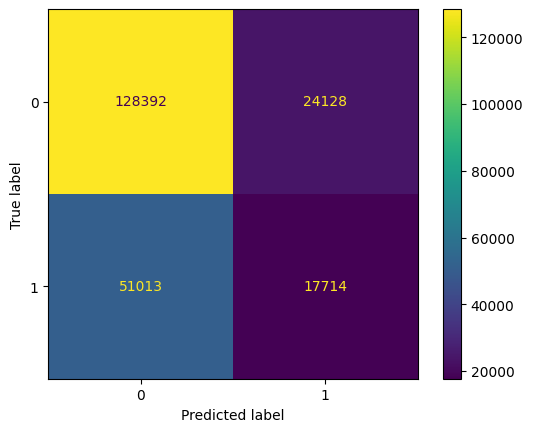

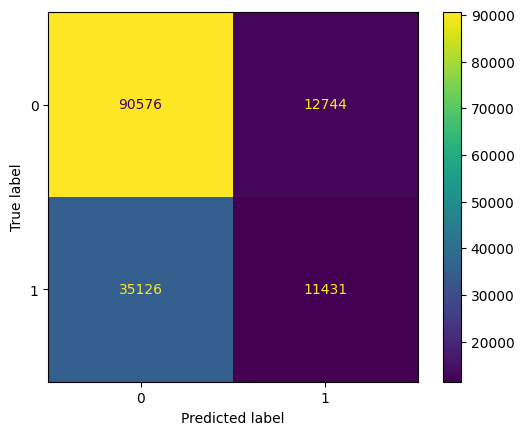

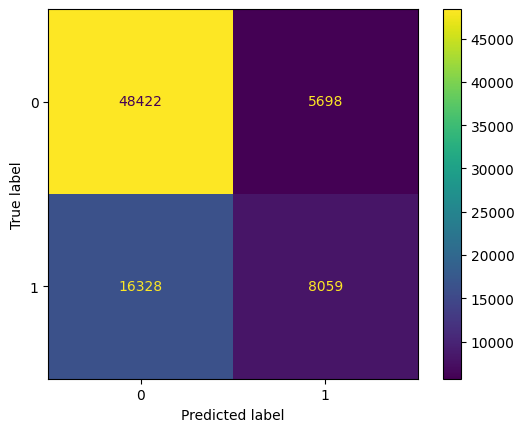

In [105]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer,Xfull,Yfull);
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer60,Xfull60,Yfull60);
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer50,Xfull50,Yfull50);
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer30,Xfull30,Yfull30);
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer20,Xfull20,Yfull20);
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer10,Xfull10,Yfull10);

C:\Users\nazar\AppData\Local\Temp\ipykernel_21292\2499032716.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Egyptian_Mau_167.jpg
cats\Abyssinian_34.jpg
cats\Egyptian_Mau_177.jpg
cats\Egyptian_Mau_145.jpg
cats\Egyptian_Mau_191.jpg
cats\Egyptian_Mau_139.jpg
86.82412314414978
Iteration 1, loss = 6.30821123
Iteration 2, loss = 3.09030847
Iteration 3, loss = 1.23668091
Iteration 4, loss = 0.66280266
Iteration 5, loss = 0.46814892
Iteration 6, loss = 0.39164630
Iteration 7, loss = 0.35366749
Iteration 8, loss = 0.32478582
Iteration 9, loss = 0.29855095
Iteration 10, loss = 0.27161651
Iteration 11, loss = 0.26327274
Iteration 12, loss = 0.24882940
Iteration 13, loss = 0.23783402
Iteration 14, loss = 0.23699384
Iteration 15, loss = 0.23310904
Iteration 16, loss = 0.22511552
Iteration 17, loss = 0.23073970
Iteration 18, loss = 0.25452683
Iteration 19, loss = 0.26694617
Iteration 20, loss = 0.25299862
Iteration 21, loss = 0.23873137
Iteration 22, loss = 0.22977952
Iteration 23, loss = 0.23562454
Iteration 24, loss = 0.25735066
Iteration 25, loss = 0.24946472
Iteration 26, loss = 0.22752031
Iterat

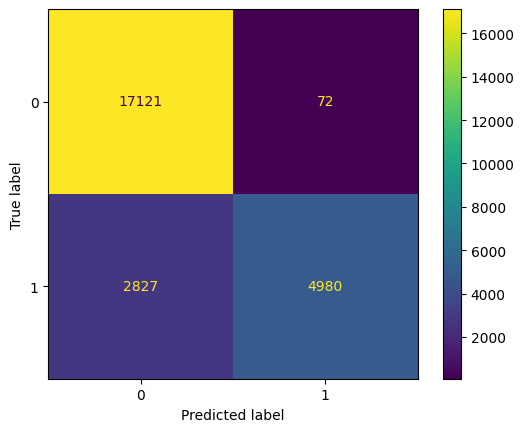

In [78]:
 MLCFFmodel3layer10 = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)
k10=[k[i] for i in ScoreBoard.iloc[-10:].index]
l10=[l[i] for i in ScoreBoard.iloc[-10:].index]
start=time.time()
Xfull10,Yfull10=form_data(read_images(),k10,l10)
end=time.time()-start
print(end)
Xtst10=Xfull10[:25000,:]
Ytst10=Yfull10[:25000]
start=time.time()
MLCFFmodel3layer10.fit(Xtst10,Ytst10)
end=time.time()-start
print(end)
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer10,Xtst10,Ytst10);

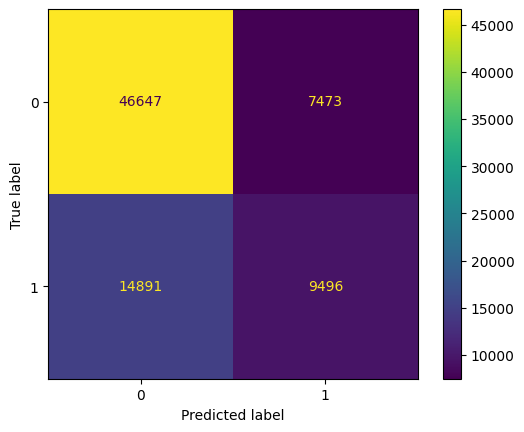

In [77]:
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer10,Xfull10,Yfull10);

C:\Users\nazar\AppData\Local\Temp\ipykernel_21292\2499032716.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(other_data)


cats\Egyptian_Mau_167.jpg
cats\Egyptian_Mau_145.jpg
cats\Abyssinian_34.jpg
cats\Egyptian_Mau_191.jpg
cats\Egyptian_Mau_177.jpg
cats\Egyptian_Mau_139.jpg
193.73135495185852
Iteration 1, loss = 6.74791557
Iteration 2, loss = 1.30956140
Iteration 3, loss = 0.52405637
Iteration 4, loss = 0.42285494
Iteration 5, loss = 0.37166792
Iteration 6, loss = 0.33676714
Iteration 7, loss = 0.28492901
Iteration 8, loss = 0.26999785
Iteration 9, loss = 0.22469201
Iteration 10, loss = 0.20759337
Iteration 11, loss = 0.18800435
Iteration 12, loss = 0.18135070
Iteration 13, loss = 0.17886300
Iteration 14, loss = 0.18621187
Iteration 15, loss = 0.15790511
Iteration 16, loss = 0.14625021
Iteration 17, loss = 0.12656831
Iteration 18, loss = 0.13783190
Iteration 19, loss = 0.18556577
Iteration 20, loss = 0.17470739
Iteration 21, loss = 0.16485941
Iteration 22, loss = 0.11579185
Iteration 23, loss = 0.10520709
Iteration 24, loss = 0.10406394
Iteration 25, loss = 0.19423204
Iteration 26, loss = 0.10028032
Itera

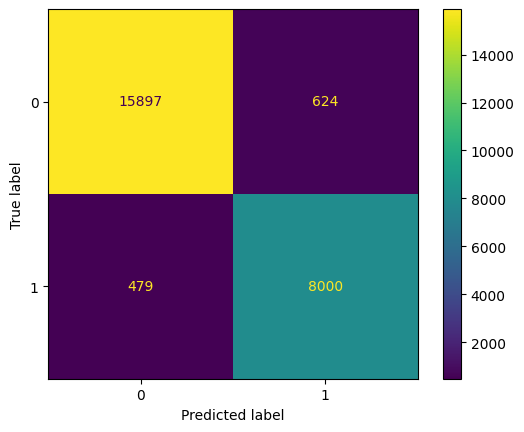

In [79]:
 MLCFFmodel3layer60 = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)
k60=[k[i] for i in ScoreBoard.iloc[-60:].index]
l60=[l[i] for i in ScoreBoard.iloc[-60:].index]
start=time.time()
Xfull60,Yfull60=form_data(read_images(),k60,l60)
end=time.time()-start
print(end)
Xtst60=Xfull60[:25000,:]
Ytst60=Yfull60[:25000]
start=time.time()
MLCFFmodel3layer60.fit(Xtst60,Ytst60)
end=time.time()-start
print(end)
ConfusionMatrixDisplay.from_estimator(MLCFFmodel3layer60,Xtst60,Ytst60);

In [95]:
Xfull.shape 
#322.2016611099243

(521001, 1024)

In [89]:
Xfull60.shape
#225.96292424201965

(435357, 1024)

In [90]:
Xfull50.shape
#200.64624881744385

(363987, 1024)

In [91]:
Xfull30.shape
#263.9829087257385

(221247, 1024)

In [92]:
Xfull20.shape
#240.80105018615723

(149877, 1024)

In [96]:
Xfull10.shape
#306.7111563682556

(78507, 1024)

In [102]:
 MLCFFmodel3layer = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(512,),
                           random_state=1, max_iter=100,verbose=True)
start=time.time()
MLCFFmodel3layer.fit(Xfull20,Yfull20)
end=time.time()-start
print(end)

Iteration 1, loss = 1.93070651
Iteration 2, loss = 0.58361738
Iteration 3, loss = 0.54053822
Iteration 4, loss = 0.51626096
Iteration 5, loss = 0.50020126
Iteration 6, loss = 0.48618320
Iteration 7, loss = 0.46687775
Iteration 8, loss = 0.44971057
Iteration 9, loss = 0.42506099
Iteration 10, loss = 0.40619352
Iteration 11, loss = 0.39087594
Iteration 12, loss = 0.37861797
Iteration 13, loss = 0.35665967
Iteration 14, loss = 0.34576488
Iteration 15, loss = 0.33507217
Iteration 16, loss = 0.32873569
Iteration 17, loss = 0.32340198
Iteration 18, loss = 0.31652621
Iteration 19, loss = 0.30973600
Iteration 20, loss = 0.30517398
Iteration 21, loss = 0.29935287
Iteration 22, loss = 0.29813314
Iteration 23, loss = 0.29164718
Iteration 24, loss = 0.28653473
Iteration 25, loss = 0.28283369
Iteration 26, loss = 0.27958060
Iteration 27, loss = 0.27875791
Iteration 28, loss = 0.26910150
Iteration 29, loss = 0.27501800
Iteration 30, loss = 0.26696979
Iteration 31, loss = 0.26710822
Iteration 32, los

C:\Users\nazar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
test_image=cv.imread("cats/Bengal_77.jpg")

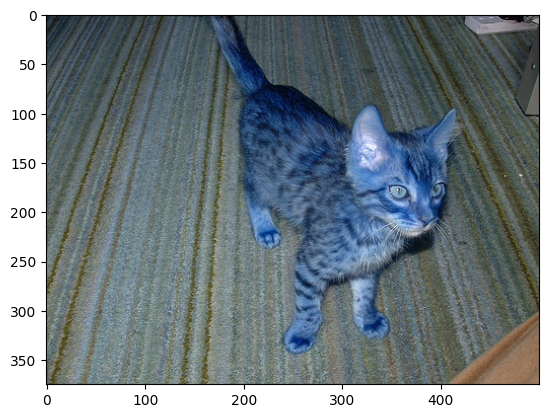

In [80]:
plt.imshow(test_image)

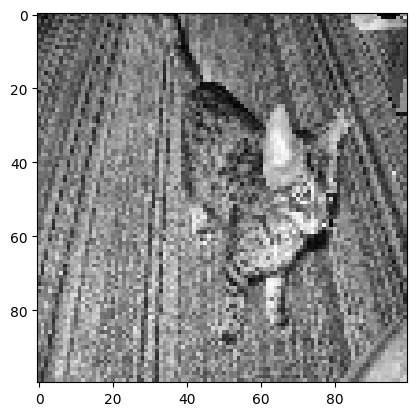

In [81]:
processed=preprocess(test_image)
plt.imshow(processed,cmap='gray')

In [82]:
_, test_features=appply_filter(processed,k,l)

In [83]:
plt.imshow(test_features[0],cmap='gray')

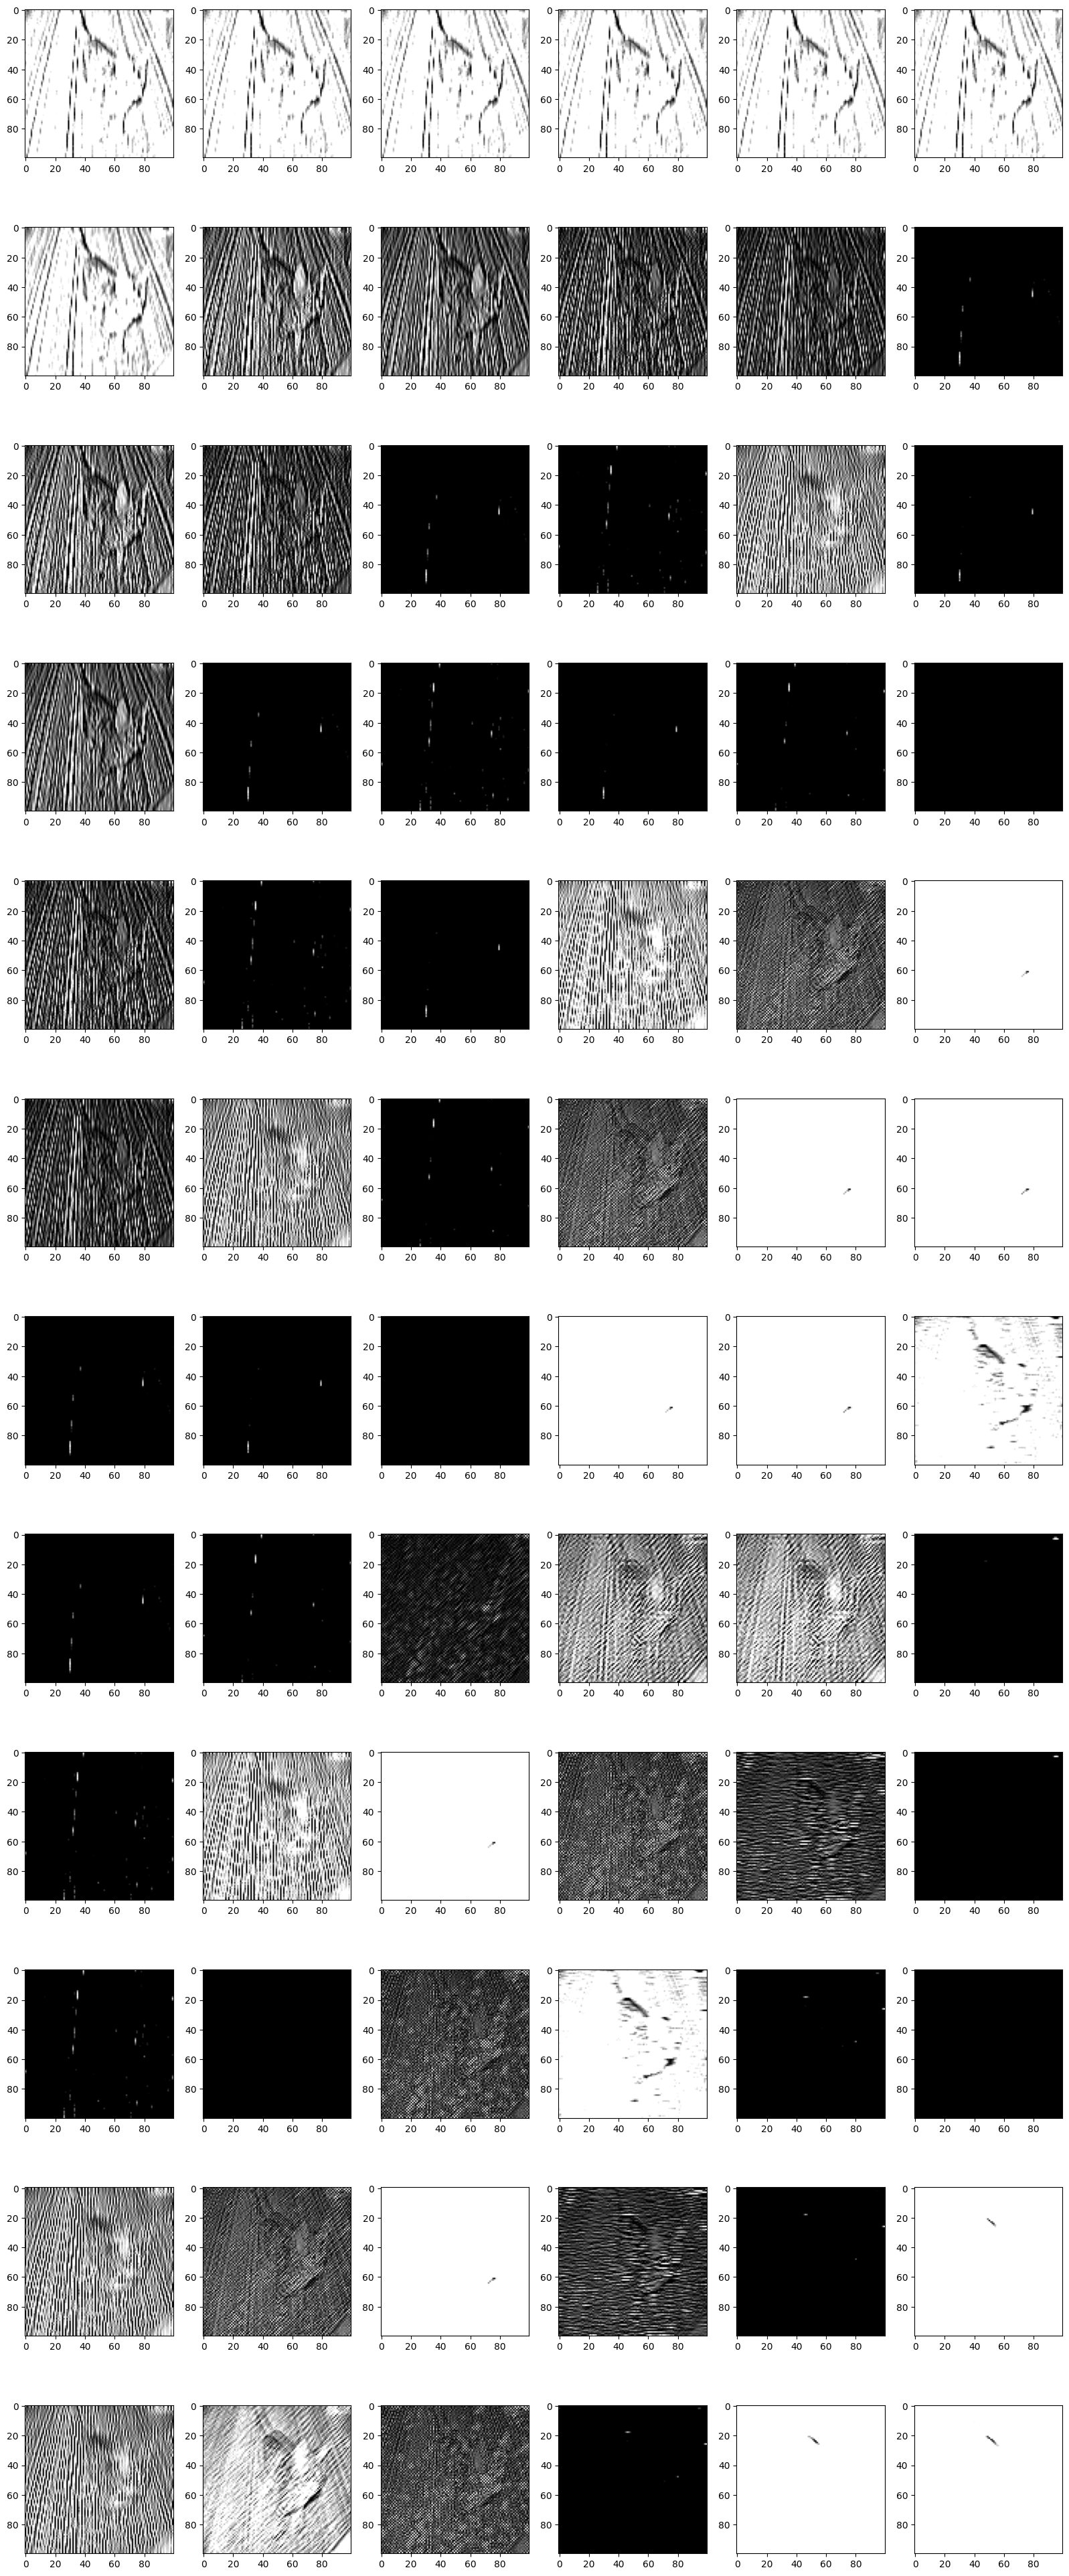

In [84]:
rows=int(np.ceil(len(k)/6))
fig, axs = plt.subplots(rows, 6,figsize=(20,50))
for i in range(6):
    for j in range(rows):
        axs[j,i].imshow(test_features[j*(i+1)],cmap='gray')

In [85]:
topk=[k[i] for i in ScoreBoard.index]
topl=[l[i] for i in ScoreBoard.index]
_, top_test_features=appply_filter(processed,topk,topl)

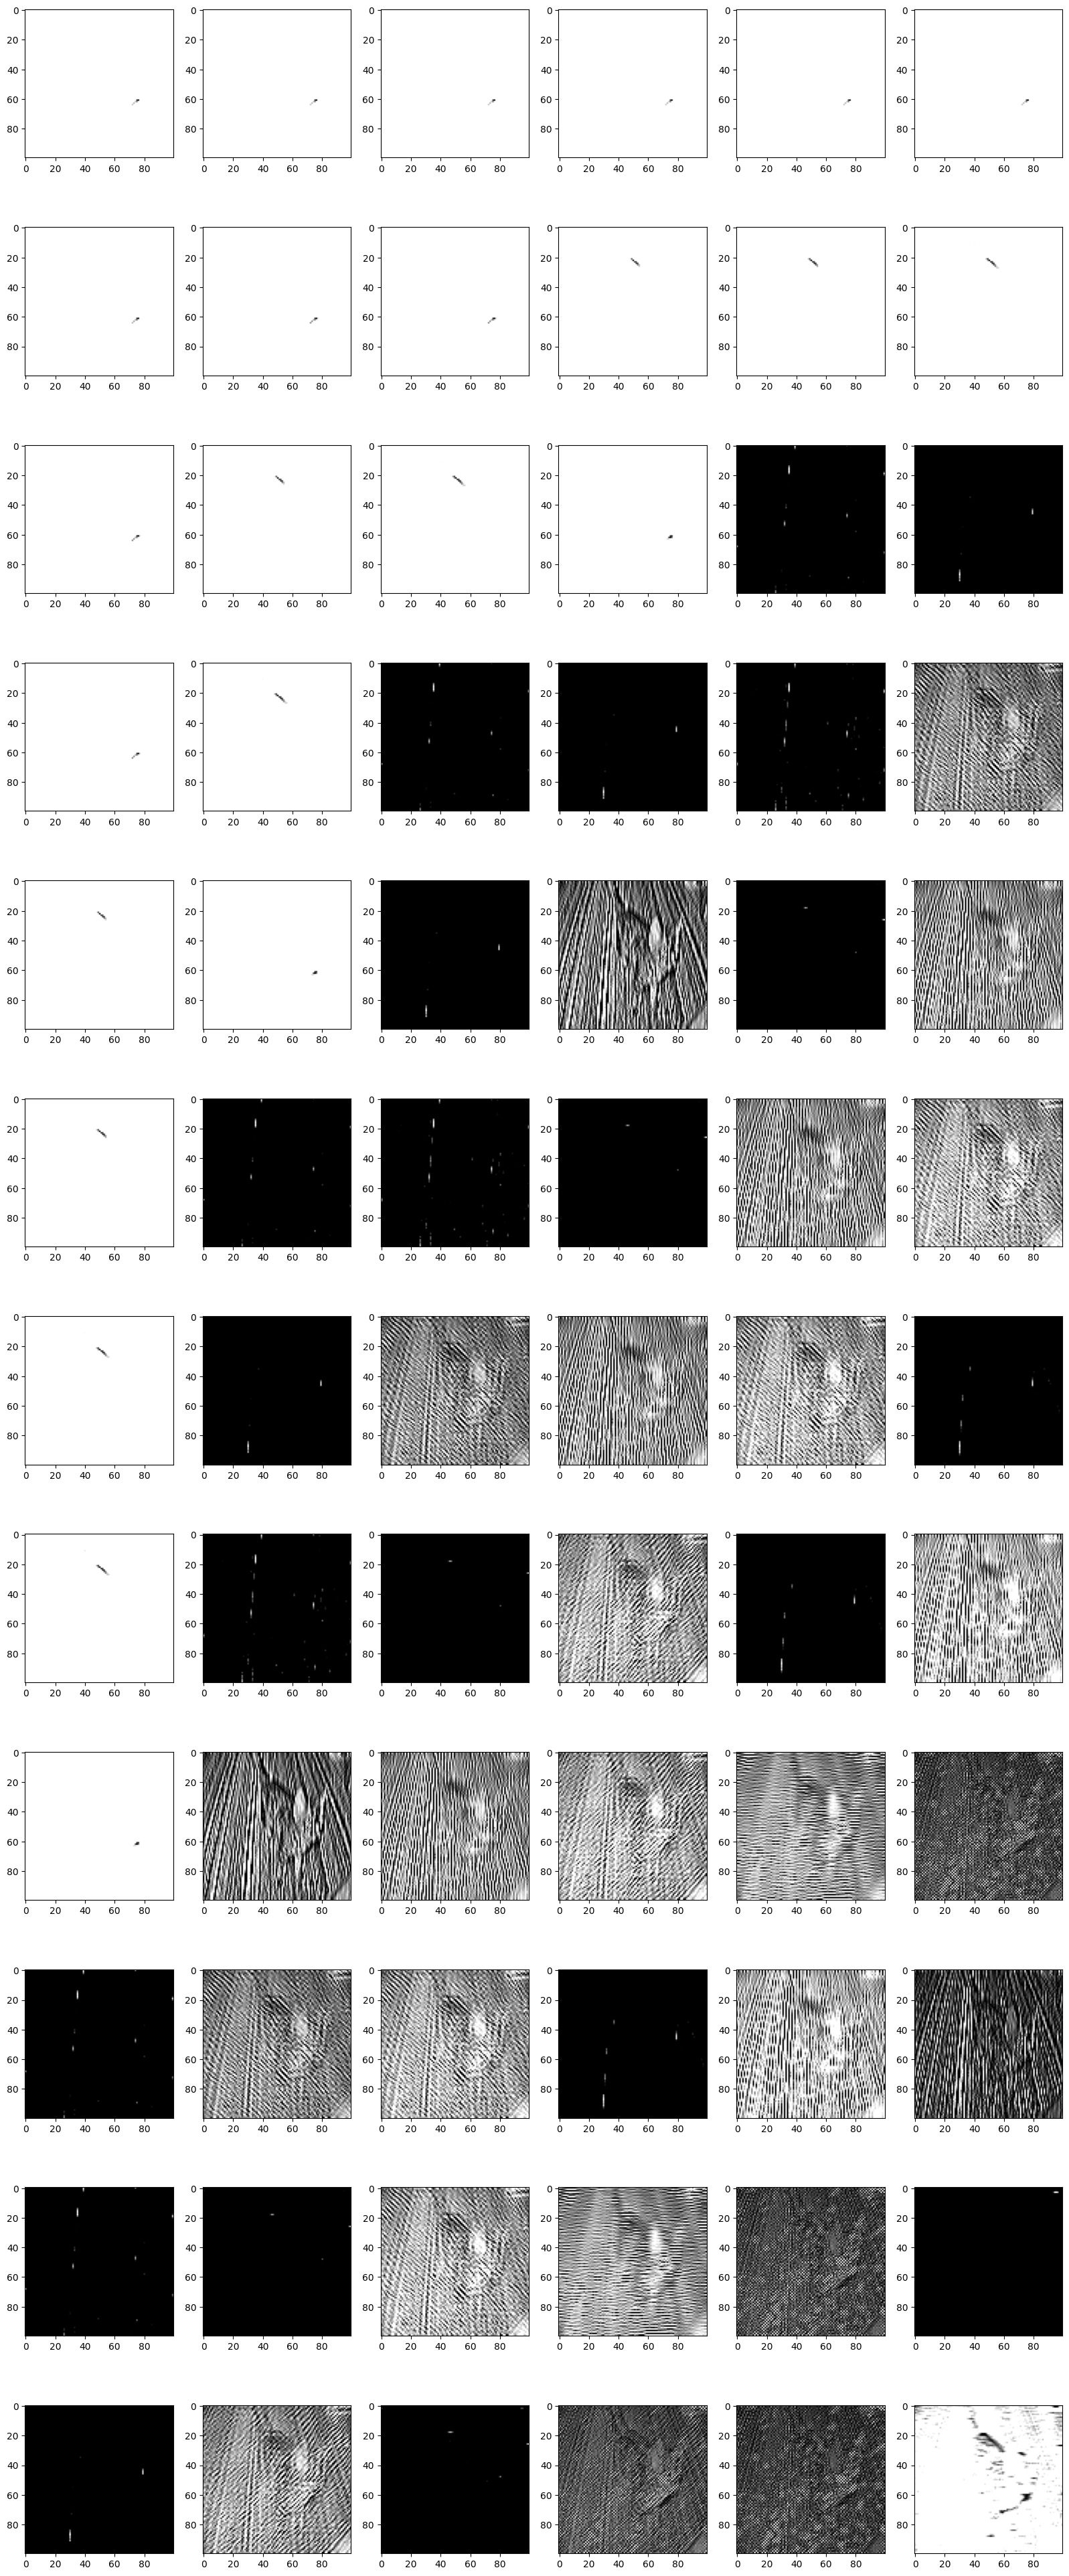

In [100]:
rows=int(np.ceil(len(top_test_features)/6))
fig, axs = plt.subplots(rows, 6,figsize=(20,50))
for i in range(6):
    for j in range(rows):
        axs[j,i].imshow(top_test_features[(j*(i+1))],cmap='gray')

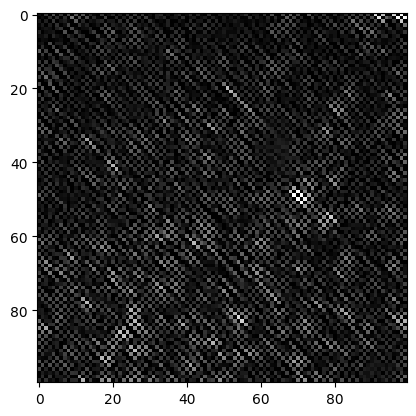

In [112]:
#21 57 47 36
plt.imshow(test_features[57],cmap='gray')

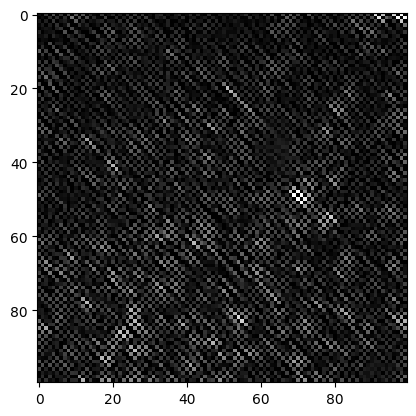

In [89]:
plt.imshow(test_features[57],cmap='gray')

In [94]:
plt.imshow(test_features[47],cmap='gray')

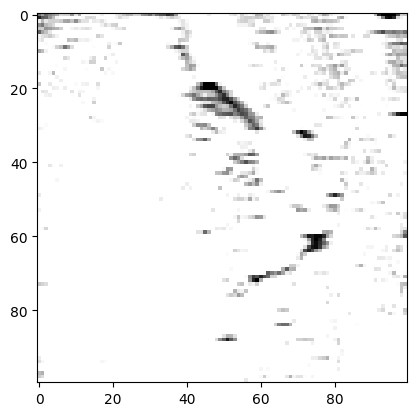

In [91]:
plt.imshow(test_features[36],cmap='gray')

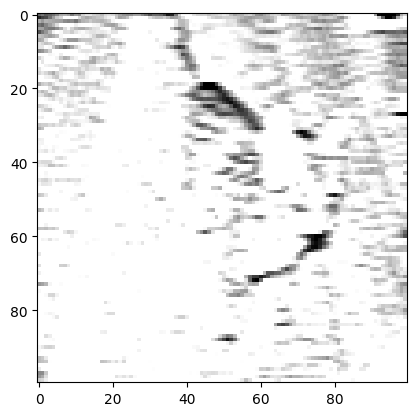

In [93]:
plt.imshow(test_features[37],cmap='gray')

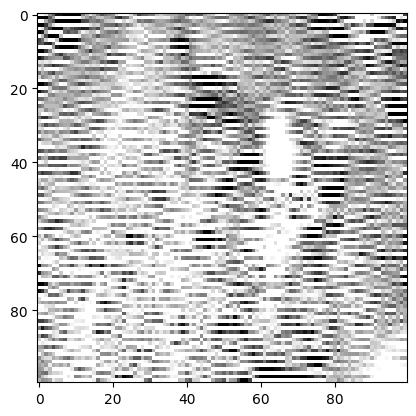

In [95]:
plt.imshow(test_features[53],cmap='gray')

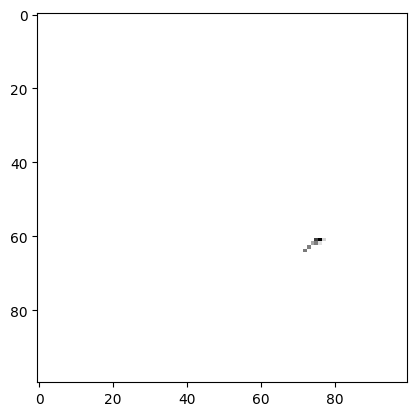

In [104]:
plt.imshow(test_features[31],cmap='gray')

In [ ]:
#24 25 30 31